In [23]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import sys, platform, os
import numpy as np
import camb
from camb import model, initialpower

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize = 18, usetex=True)

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# Exercise 1

Assuming the following cosmological model ($\Omega_{m} = 0.25, \Omega_{b} = 0.044, \Omega_{\nu} = 0, n_{s} = 0.95, \sigma_{8} = 0.75, h = 0.7$ and a flat Universe) run CAMB to output a linear power spectrum and a linear transfer function at z = 0. Are they related in the way we discussed in class ? (explain how they should related to each other and plot this).

## Model Setup

The `.set_cosmology` function can take a variety of input parameters. In this exercise, we are interested in using `H0` (Hubble param, in km/s/Mpc), `omch2` (physcal density in cold dark matter), `ombh2` (physical density in baryons) and `omk` (Omega_K curvature parameter). 

In [235]:
h = 0.7
Om = 0.25
Ob = 0.044
Onu = 0.0
Ok = 0.0
s8 = 0.75
ns = 0.95

In [236]:
H0 = 100*h
Omch2 =(Om*h**2)-(Ob*h**2)-(Onu**2) #physcal density in cold dark matter
Ombh2 = Ob*h**2
print("Omh2 = {0:0.3f}, Omh2 = {1:0.3f}".format(Omch2, Ombh2))

Omh2 = 0.101, Omh2 = 0.022


In [237]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, omch2=Omch2, ombh2=Ombh2, omk = Ok, mnu = 0.0)
pars.InitPower.set_params(As=2e-9, ns = 0.95, r = 0) #r = tensor to scalar ratio at pivot
pars.set_matter_power(redshifts=[0])

prelim_results = camb.get_results(pars)
s8_init = np.array(prelim_results.get_sigma8())[0]
print("Preliminary sigma8: {0:0.2f}".format(s8_init))

Preliminary sigma8: 0.72


In [238]:
As_new =2e-9*(s8/s8_init)**2
pars.InitPower.set_params(As = As_new, ns = 0.95, r = 0)
results = camb.get_results(pars)
s8 = np.array(results.get_sigma8())[0]
print("New sigma8: {0:0.2f}".format(s8))

New sigma8: 0.75


In [245]:
Olambda = pars.omegav #dark energy
print(Olambda)

0.75


In [240]:
print(pars.omegan, pars.omegab, pars.omegak)

0.0 0.044 0.0


Set z = 0 (as dictated by the exercise) and calculate the matter power spectra and transfer functions with the `set_matter_power` function. 

In [246]:
pars.set_matter_power(redshifts=[0, 0.5])
results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


Calculates transfer functions and power spectra.

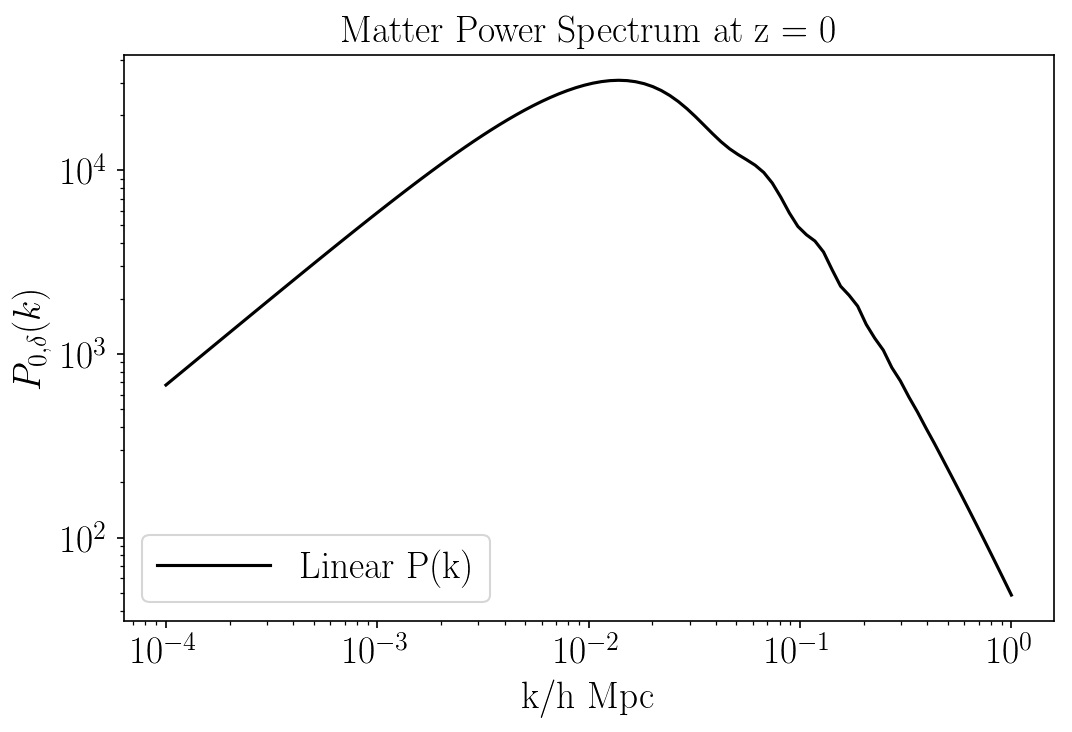

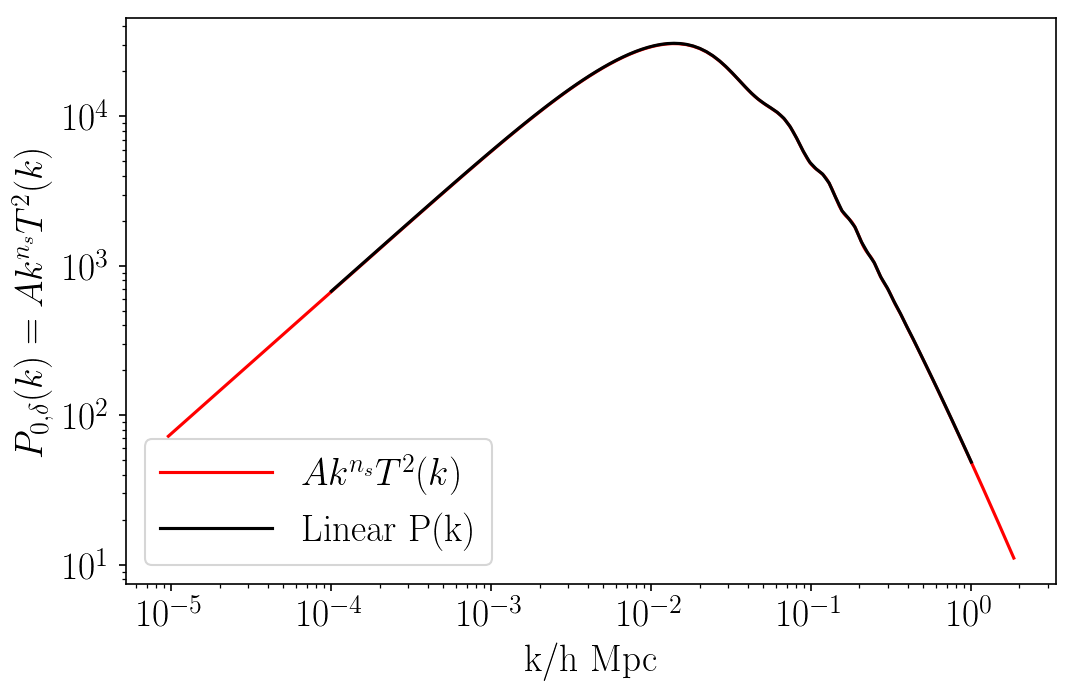

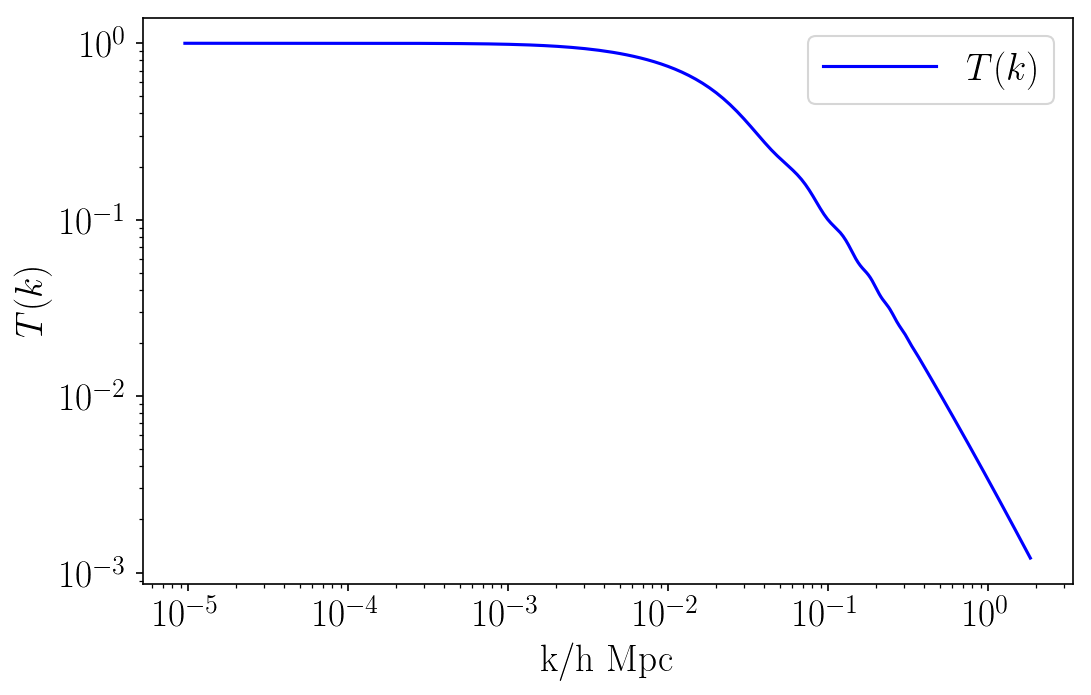

In [277]:
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum()#minkh=1e-4, maxkh=1, npoints=200)
mtrans = results.get_matter_transfer_data()
transfer_k = mtrans.transfer_z('delta_cdm')

plt.figure()
plt.loglog(kh, pk[0,:], '-k', label = r'Linear P(k)')
plt.legend()
plt.xlabel('k/h Mpc'); plt.ylabel(r'$P_{0,\delta}(k)$')
plt.title(r'Matter Power Spectrum at z = 0')
plt.savefig('ex1_pk.png')

plt.figure()
plt.loglog((mtrans.q)/h,(mtrans.q**ns)*(transfer_k**2)/5e7, linestyle = '-', color = 'r',label = r'$Ak^{n_s}T^2(k)$') #in a flat universe, q = k. 
plt.loglog(kh, pk[0,:], color='k', label = r'Linear P(k)')
plt.legend()
plt.xlabel('k/h Mpc'); plt.ylabel(r'$P_{0,\delta}(k)=Ak^{n_s}T^2(k)$')
plt.savefig('ex1_t_comparison.png')

plt.figure()
plt.loglog((mtrans.q)/h,transfer_k/np.max(transfer_k), color = 'b', label = r'$T(k)$') #in a flat universe, q = k. 
plt.legend()
plt.xlabel('k/h Mpc'); plt.ylabel(r'$T(k)$')
plt.savefig('ex1_t.png')


#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum()#    minkh=1e-4, maxkh=1, npoints=200)

# Ex. 4

In [14]:
Orh2 = 4*10**-5 
Omh2 = Om*h
c = 3*10**5
print(Omh2)
zeq = ((Om*(h**2))/(Orh2))-1
print(zeq)
print(1+zeq)

0.175
3061.4999999999995
3062.4999999999995


In [15]:
sqr_simple = np.sqrt(2/Orh2)
keq_simple = 100*Omh2*sqr_simple/c
print("keq (simple eq'n) = {0:0.13f} h/Mpc".format(keq_simple))

keq (simple eq'n) = 0.0130437298687 h/Mpc


In [16]:
sqr_full = np.sqrt(2*Om*(1+zeq) + (Olambda/((1+zeq)**2)))
keq_full = (100*sqr_full)/c #in units of h/Mpc
 
print("keq (full eq'n) = {0:0.13f} h/Mpc".format(keq_full))

keq (full eq'n) = 0.0130437298691 h/Mpc


In [17]:
#check to the above:
test = ((2*0.25*(1+zeq)**3)+0.75)**(1/2)*(100/(c*(1+zeq)))
print(test)

0.013043729869089365


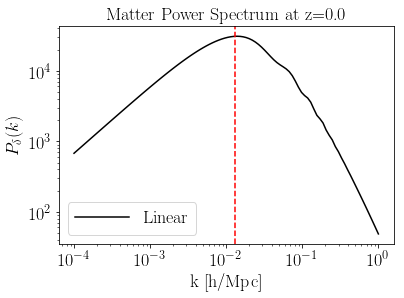

In [18]:
plt.loglog(kh, pk[0, :], color='k', label = 'Linear')
plt.title(r'Matter Power Spectrum at z=%s' % z[0])
plt.legend()
plt.xlabel('k [h/Mpc]'); plt.ylabel(r'$P_{\delta}(k)$')
plt.axvline(keq_full, color='r', ls='--')
plt.savefig('ex4.png', dpi=400)

The horizon size at matter-radiation equality roughly corresponds to the maximum of the matter power spectrum. At large scales (small k), $P(k) \propto k$ and $P(k)\propto k^{-3}$ at small scales (big k). This turnover exists bc the perturbations that enter the horizon before $z_{eq}$ remain constant 

# Exercise 5

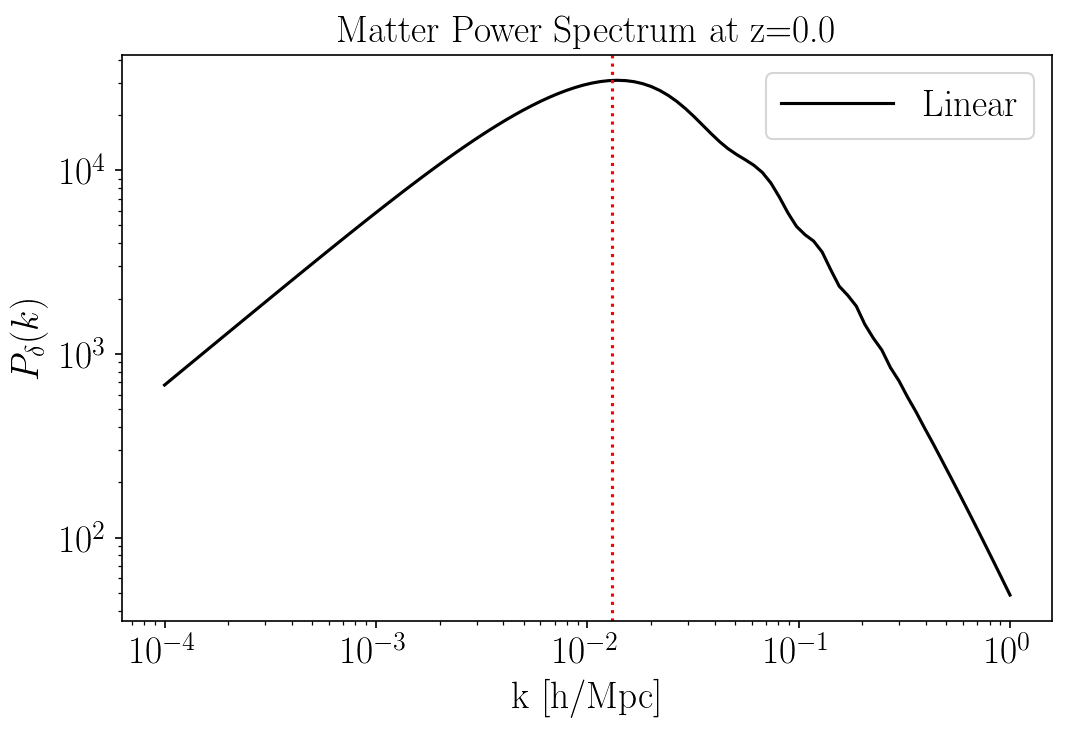

In [216]:
plt.loglog(kh, pk[0, :], color='k', label = 'Linear')
plt.title(r'Matter Power Spectrum at z=%s' % z[0])
plt.legend()
plt.xlabel('k [h/Mpc]'); plt.ylabel(r'$P_{\delta}(k)$')
plt.axvline(keq_full, color='r', ls=':')
plt.savefig('ex4.png', dpi=400)

In [219]:
kgrid = np.linspace(1e-4,10,1e4)
def pdelta(k, keq, case):
    if case == 1: T = 1.
    elif case == 2: T = np.log(k/keq)*(keq/k)**2
    else: T = 0.
    return (k**ns)*(T**2)

kless = kgrid[kgrid<keq_full]
kgreat =  kgrid[kgrid>keq_full]

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


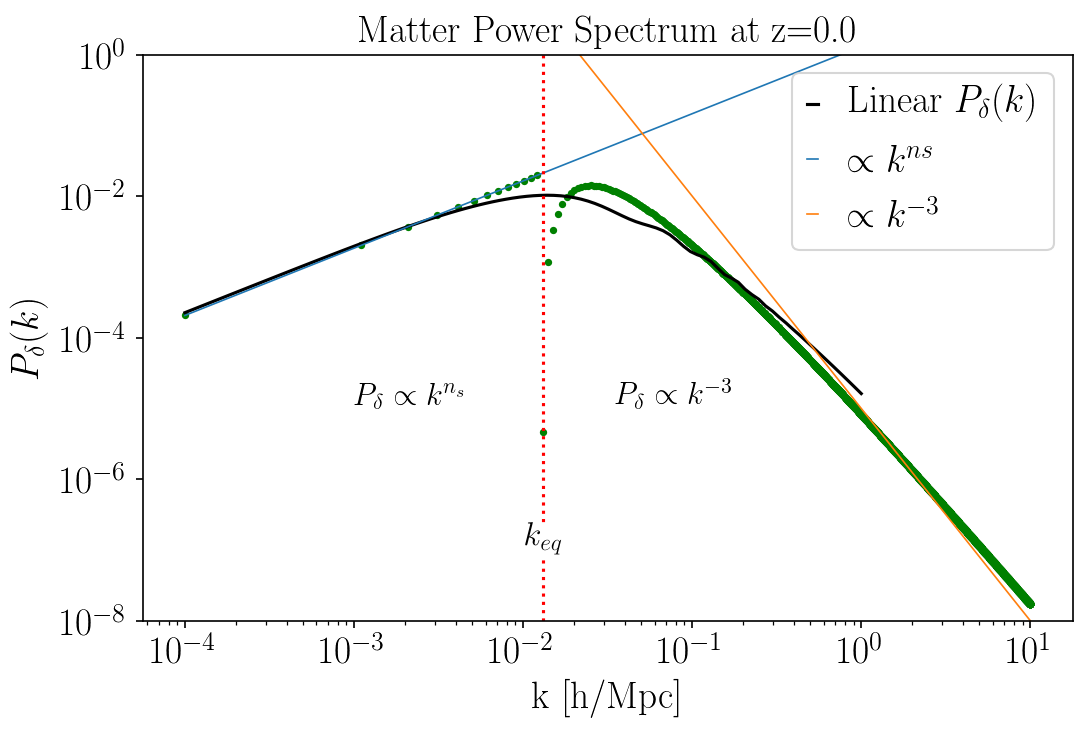

In [234]:
import matplotlib.patheffects as PathEffects
plt.loglog(kless,pdelta(kless,keq_full,1)*1.3,'.',color='g', linewidth=1, markersize=5)
plt.loglog(kgreat,pdelta(kgreat,keq_full,2)*15.,'.',color='g', linewidth=1, markersize=5)
plt.loglog(kh, pk[0, :]/3e6, color='k', label = r'Linear $P_{\delta}(k)$')
 
plt.loglog(kgrid, (kgrid**ns)*1.3, label = '$\propto k^{ns}$', linewidth=0.8)
plt.loglog(kgrid, (kgrid**-3)/1e5, label = '$\propto k^{-3}$',linewidth=0.8)

plt.axvline(keq_full, color='r', ls=':')
plt.text(1e-3,1e-5, r"$P_\delta \propto k^{n_s}$", fontsize=15)
plt.text(0.035,1e-5, r"$P_\delta \propto k^{-3}$", fontsize=15)
txt = plt.text(keq_full-3e-3, 1e-7, "$k_{eq}$",fontsize=16)
txt.set_path_effects([PathEffects.withStroke(linewidth=8, foreground='w')])

plt.ylim([1e-8,1]);
plt.title(r'Matter Power Spectrum at z=%s' % z[0])
plt.xlabel('k [h/Mpc]'); plt.ylabel(r'$P_{\delta}(k)$')
plt.legend(loc='upper right', handlelength = 0.3);

# Exercise 6

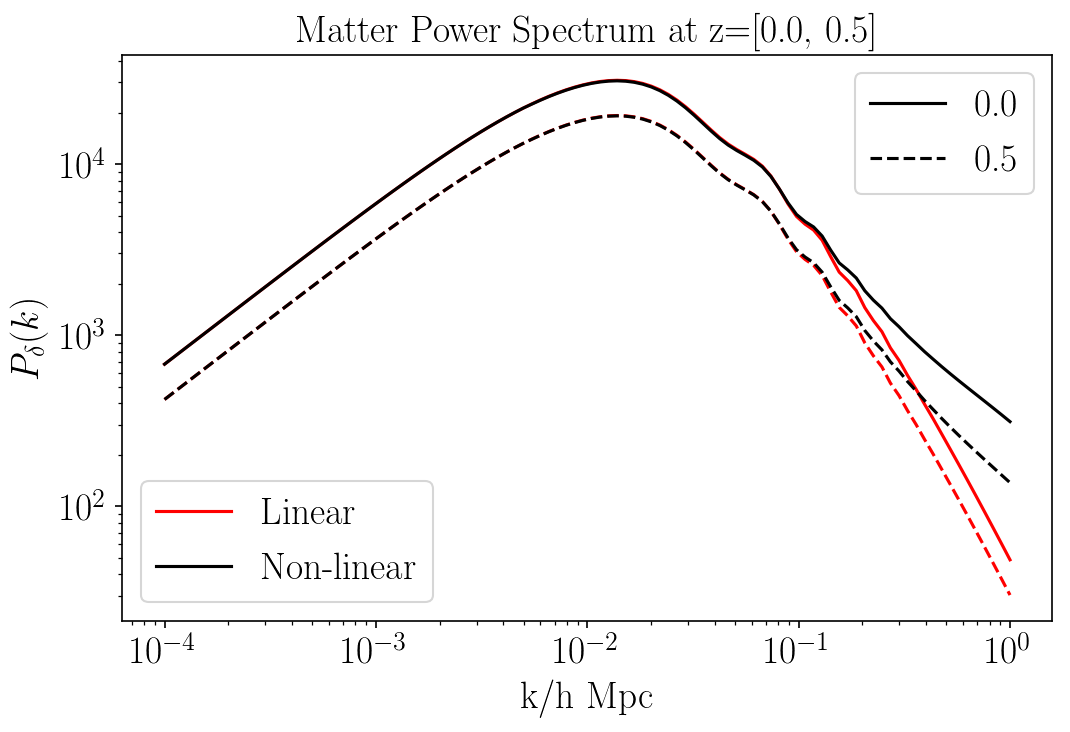

In [32]:
z_legend = [mlines.Line2D([],[],ls=ls,label=str(z),c='k') for z,ls in zip(z,['-','--'])]

for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, pk[i,:], color='r', ls = line, label = 'Linear')
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='k', ls = line, label = 'Nonlinear')
    
plt.xlabel('k/h Mpc'); plt.ylabel(r'$P_{\delta}(k)$')
plt.title(r'Matter Power Spectrum at z=%s' % z)
leg2 = plt.legend(handles = z_legend, handlelength = 2)
plt.gca().add_artist(leg2)
plt.savefig('ex6_Pk.png')

plt.legend(['Linear','Non-linear'],loc='lower left', handlelength = 2);

In [114]:
def find_scale(k, delta):
    res = 0
    for i in range(len(k)):
        if (delta[i] >= 1.):
            res = i
            break
    return res

In [115]:
lin1_z0 = find_scale(kh,((kh**3)*pk[0,:])/(2*np.pi**2))
k0 = kh[lin1_z0]
lin1_z05 = find_scale(kh,((kh**3)*pk[1,:])/(2*np.pi**2))
k05 = kh[lin1_z05]

nonlin1_z0 = find_scale(kh_nonlin,((kh_nonlin**3)*pk_nonlin[0,:])/(2*np.pi**2))
k0_nonlin = kh_nonlin[nonlin1_z0]
nonlin1_z05 = find_scale(kh_nonlin,((kh_nonlin**3)*pk_nonlin[1,:])/(2*np.pi**2))
k05_nonlin = kh_nonlin[nonlin1_z05]

x_lin = [k0, k05]
x_nonlin = [k0_nonlin, k05_nonlin]

Linear (z = 0, z = 0.5): 0.32745491628777273 0.5722367659350214
Nonlinear (z = 0, z = 0.5): 0.24770763559917106 0.3593813663804622


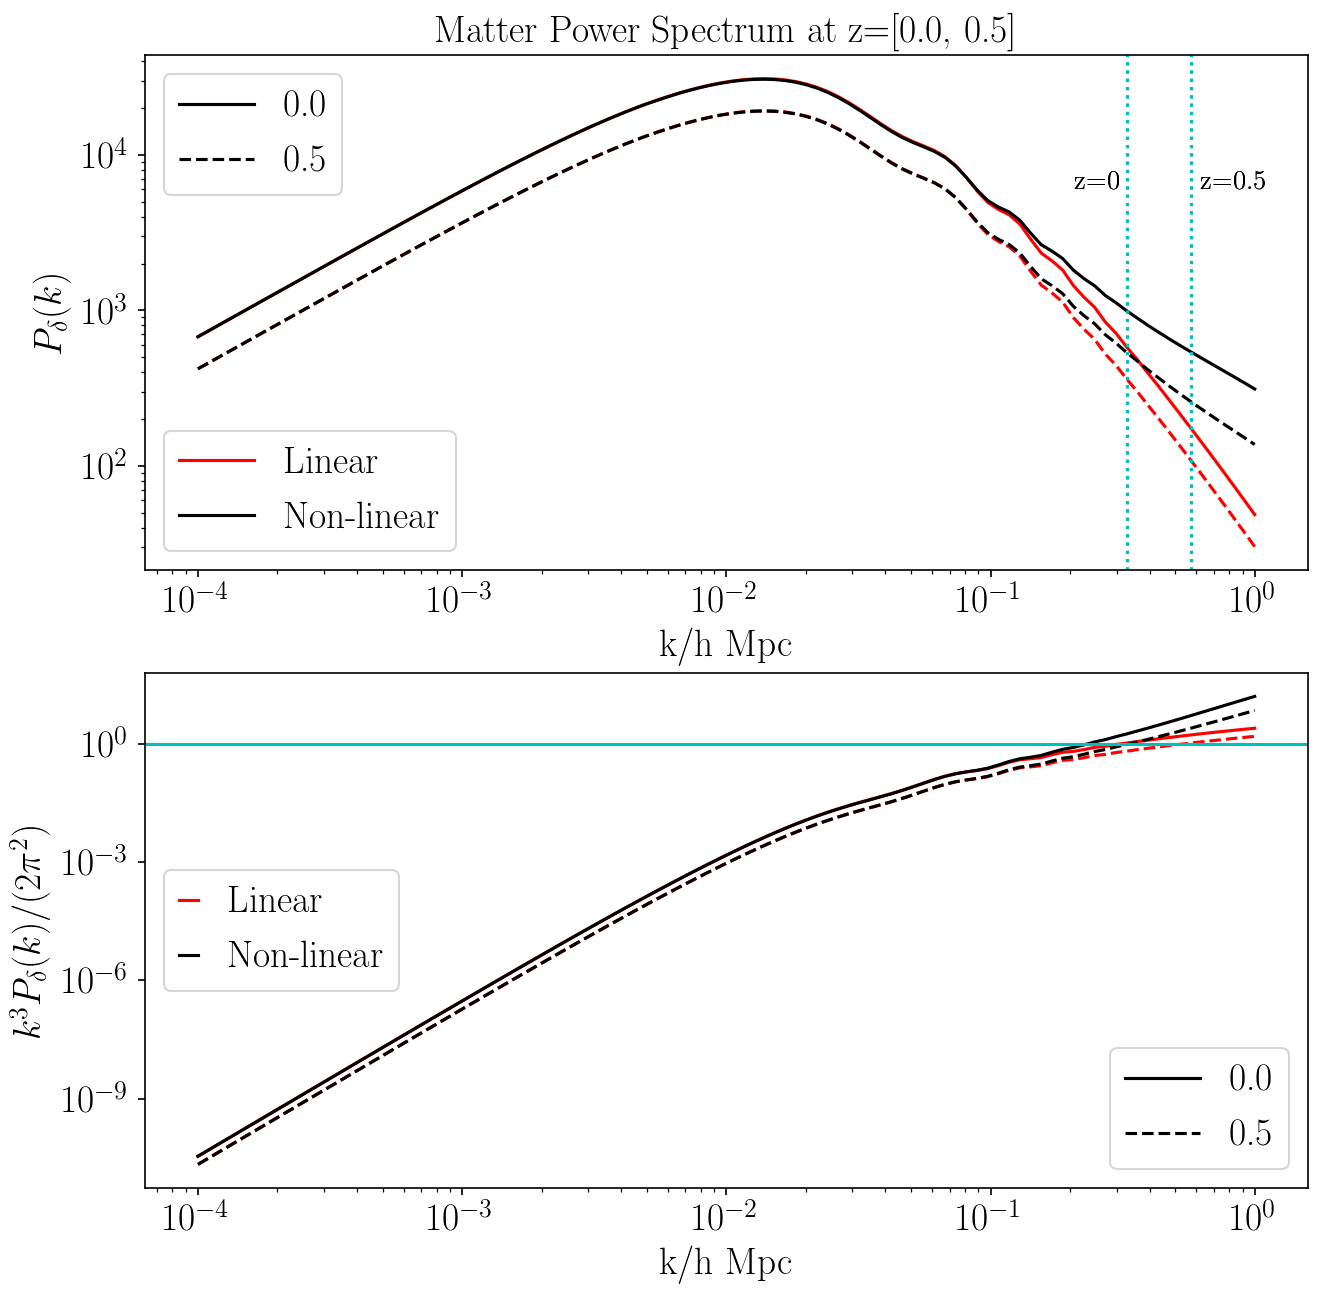

In [144]:
z_legend = [mlines.Line2D([],[],ls=ls,label=str(z),c='k') for z,ls in zip(z,['-','--'])]

plt.figure(figsize=(10,10))
plt.subplot(211)
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, pk[i,:], color='r', ls = line, label = 'Linear')
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='k', ls = line, label = 'Nonlinear')
for xc in x_lin: 
    plt.axvline(x=k0, color='c', linestyle =':')
    plt.axvline(x=k05, color='c',linestyle =':')
    plt.text(k0-0.12,6e3,'z=0',fontsize='13')
    plt.text(k05+0.05,6e3,'z=0.5',fontsize='13')
#    plt.axvline(x=k0_nonlin, color='g',linestyle =':')
#    plt.axvline(x=k05_nonlin, color='g',linestyle =':')

plt.xlabel('k/h Mpc'); plt.ylabel(r'$P_{\delta}(k)$')
plt.title(r'Matter Power Spectrum at z=%s' % z)
leg2 = plt.legend(handles = z_legend, handlelength = 2)
plt.gca().add_artist(leg2)
plt.legend(['Linear','Non-linear'],loc='lower left', handlelength = 2);

plt.subplot(212)
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, ((kh**3)*pk[i,:])/(2*np.pi**2), ls = line, color='r', label = 'Linear')
    plt.loglog(kh_nonlin, ((kh_nonlin**3)*pk_nonlin[i,:])/(2*np.pi**2), ls = line,  color='k', label = 'Nonlinear')
plt.axhline(y=1,color='c')
plt.xlabel('k/h Mpc'); plt.ylabel(r'$k^{3}P_{\delta}(k)/(2\pi^{2})$')
leg2 = plt.legend(handles = z_legend, handlelength = 2)
plt.gca().add_artist(leg2)
plt.legend(['Linear','Non-linear'],loc='center left', handlelength = 0.5);
plt.savefig('ex6.png')

print("Linear (z = 0, z = 0.5):", k0,k05)
print("Nonlinear (z = 0, z = 0.5):", k0_nonlin, k05_nonlin)